# پروژه امتیازی یادگیری ماشین
### حمید خدادادی 810197499
### نازنین یوسفیان 810197610

# تشخیص نارسایی قلبی با استفاده از random forest

## مقدمه
#### در این پروژه بر اساس الکتروکاردیوگرام (ECG) تعدادی بیمار قرار است که یک طبقه بند ارائه کنیم. این کار در دو مرحله انجام شده است : 
#### 1. استخراج ویژگی ها بر اساس روش autoregressive burg
#### 2. طبقه بندی داده ها با 5 طبقه بند متفاوت اعم از شبکه عصبی، درخت تصمیم، نزدیک ترین همسایگی، random forest و SVM
#### دقت هر طبقه بند بر اساس معیارهای accuracy، f1-score و سطح نمودار ROC سنجیده شده است.

## بخش اول - استخراج ویژگی ها
#### داده ها از 3 دیتاست به دست آمده اند. دسته اول سیگنال ECG از 15 بیمار است که نارسایی قلبی دارند. این داده ها از دیتابیس BIMDC congestive heart failure به دست آمده اند که طی 20 ساعت رکورد شده است. برای هر فرد دو سیگنال وجود دارد. دیتاست بعدی متشکل از 3 بیمار است که در دیتابیس PTB Diagnostic ECG ذخیره شده اند. 15 سیگنال موازی رکورد شده است. دیتاست آخر مربوط به افراد سالم است که از 48 سیگنال ECG تشکیل شده است و هرکدام به مدت 30 دقیقه رکورد شده اند.
#### برای به دست آوردن دو دیتاست مورد نظر، داده مربوط به افراد سالم همراه با هر یک از دو دیتاست دیگر در نظر گرفته شده است و نتایج حاصل از استخراج ویژگی به ترتیب در دو فایل csv با نام dataset1 و dataset2 گردآوری شده است که از لینک زیر قابل دسترسی است.


#### *https://drive.google.com/drive/folders/11hrFiC536H4p_9L86-JCGBbp3HlkJNEq?usp=sharing*

#### ابتدا فایل dat. مربوط به هر فرد توسط کتابخانه wfdb خوانده شده است. سپس سیگنال به دست آمده به زیردسته هایی تقسیم شده است که هر کدام شامل 1000 دیتاپوینت باشند. پس از آن برای هر زیردسته با استفاده از autoregressive Burg method ویژگی ها استخراج شده اند و نتیجه های نهایی در فایل csv ذخیره شده اند.
#### روش Burg بدین صورت عمل می کند که یک مدل autoregressive (AR) را بر روی ورودی با مینیمم کردن خطای RMS در تخمین forward و backward فیت می کند. مدل AR یک نمایش از پروسس رندوم است؛ به طور مثال برای پروسس های متغیر با زمان در طبیعت به کار می رود. این مدل مشخص می کند که خروجی به طور خطی به مقادیر قبلی  و یک متغیر تصادفی وابسته است. از این مدل به خصوص برای استخراج ویژگی از سیگنال های بیولوژیکی استفاده می شود.  
#### یک مدل با order p به صورت زیر قابل نمایش است:


![title](img\1.png)

#### در روش Burg مقدار ak به صورت بازگشتی توسط ak قبلی با p - 1 تخمین زده می شود. تعیین مقدار p تاثیر زیادی در دقت این روش دارد . در ابتدا با افزایش آن، مقدار خطای RMS کاهش می یابد و پس از نقطه ای این خطا ثابت می شود. این نقطه برای p مناسب است. در اینجا از p = 32 استفاده شده است. طول بردار ویژگی به دست آمده برابر با 33 است.
#### در ادامه تابعی با نام extract_features برای انجام این محاسبات تعریف شده است. با گرفتن نام فایل ورودی، هر سیگنال به دسته های 1000 تایی تقسیم شده و الگوریتم Burg روی آن اجرا می شود. رکورد حاصل را می توان به صورت یک data frame ذخیره کرد. 

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import log_loss

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


import warnings
warnings.filterwarnings('ignore')

In [7]:
import wfdb
from spectrum import arma2psd, arburg
def extract_features(filename, label):
    records = []
    labels = []
    sig, fields = wfdb.rdsamp(filename)
    sig_split = np.array_split(sig, len(sig)//1000+1)
    for j in range(len(sig_split)):
        for k in range(sig.shape[1]):
            AR, rho, ref = arburg(sig_split[j][:,k], 32)
            PSD = arma2psd(AR, rho=rho, NFFT=64)
            PSD = PSD[len(PSD):len(PSD)//2-2:-1]
            records.append(PSD)
            labels.append(label)
    return records, labels

#### در ادامه به ازای یک سیگنال با 1000 دیتاپوینت، نمودار اولیه و نمودار آن پس از استخراج ویژگی ها نشان داده شده است.

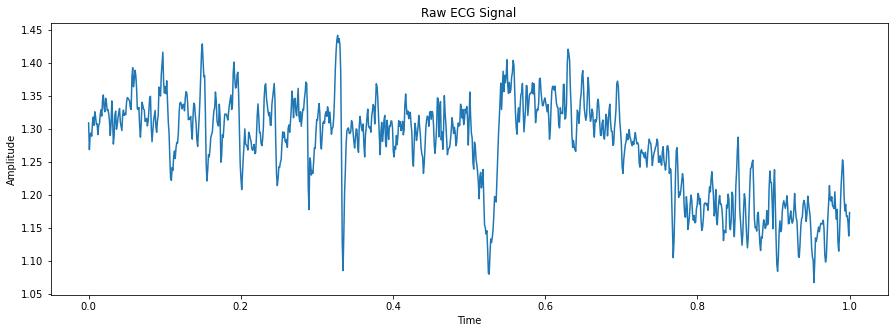

In [17]:
sig, fields = wfdb.rdsamp('s0224_re')
sig_split = np.array_split(sig, len(sig)//1000+1)
signal = sig_split[0][:,3]



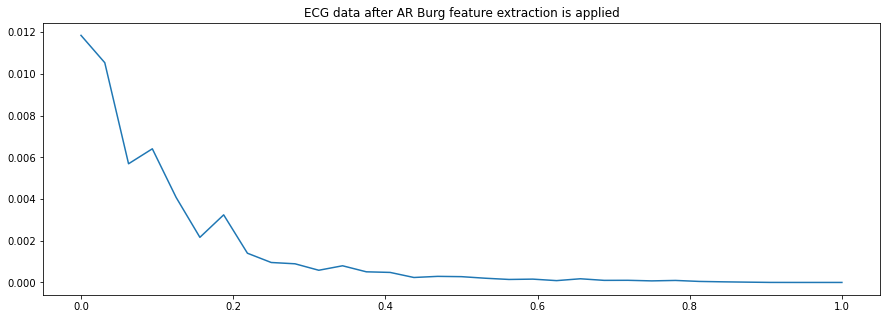

In [18]:
AR, rho, ref = arburg(signal, 32)
PSD = arma2psd(AR, rho=rho, NFFT=64)
PSD = PSD[len(PSD):len(PSD)//2-2:-1]
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, 1, len(PSD)), PSD)
plt.title('ECG data after AR Burg feature extraction is applied')
plt.show()

## بخش دوم - طبقه بندها
#### قبل از پیاده سازی طبقه بندها لازم است که داده ها نرمالایز شوند. بدین منظور از MinMaxScaler استفاده شده که داده ها را در بازه 0 تا 1 قرار می دهد. پس از آن برای تشخیص دقت مدل ها و مقایسه آن ها با یکدیگر از k-fold cross validation استفاده شده است. دیتا به k دسته تقسیم می شود و هر بار یکی از آن ها به عنوان تست و k -1 دسته دیگر برای آموزش استفاده می شوند. این کار k بار تکرار می شود. در اینجا از k = 10 استفاده شده است. 
#### دو تابع به نام roc_area و report تعریف شده اند که اولی برای محاسبه سطح نمودار ROC و دومی برای گزارش دقت طبقه بند استفاده می شود. 

In [20]:
data = pd.read_csv('dataset2.csv')
health = {'healthy':1, 'heart failure' : 0}
data['label'] = data['label'].map(health)
modelData = data.drop(['label'], axis=1)
labels = data['label']

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(modelData)
modelData_scaled = scaler.transform(modelData)

In [22]:
kf = KFold(n_splits=10, shuffle=True, random_state=40)

In [23]:
def roc_area(y_true, y_pred):
    fpr, tpr, _ =  roc_curve(y_true, y_pred)
    roc_auc =  auc(fpr, tpr)
    return roc_auc 

In [24]:
def report(acc_normals, acc_chfs, f1_normals, f1_chfs, roc_normals, roc_chfs):
    acc_normal = 0
    acc_chf = 0
    f1_normal = 0
    f1_chf = 0
    roc_normal = 0
    roc_chf = 0
    for i in range(10):
        acc_normal += acc_normals[i]
        acc_chf += acc_chfs[i]
        f1_normal += f1_normals[i]
        f1_chf += f1_chfs[i]
        roc_normal += roc_normals[i]
        roc_chf += roc_chfs[i]
    print('Normal')
    print('accuracy = ', round( acc_normal/10, 3))
    print('f1 = ' , round(f1_normal/10, 3))
    print('ROC area = ', round(roc_normal/10, 3))
    print('CHF')
    print('accuracy = ',  round(acc_chf/10, 3))
    print('f1 = ', round(f1_chf/10, 3))
    print('ROC area = ', round(roc_chf/10, 3))

### طبقه بند KNN
#### knn یک روش non-parametric است که بر اساس پیدا کردن نزدیک ترین مجموعه داده کار می کند. ابتدا ابعاد ویژگی ها با استفاده از یک تابع فاصله مانند Euclidian که بین مجموعه تست و آموزش محاسبه می شود، کاهش می یابد و سپس نزدیک ترین آن ها به عنوان دسته نهایی انتخاب می شود. در این الگوریتم پیدا کردن هایپرپارامتر k اهمیت دارد که با k = 10 بیشترین دقت حاصل می شود. 

In [63]:
acc_normal = []
acc_chf = []
f1_normal = []
f1_chf = []
roc_normal = []
roc_chf = []
for train_index, test_index in kf.split(modelData_scaled):
    x_train, x_test = modelData_scaled[train_index], modelData_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    KNN = KNeighborsClassifier(n_neighbors=3, weights='distance')
    KNN.fit(x_train, y_train)
    y_pred = KNN.predict(x_test)
    m = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[1, 0])
    acc_normal.append((m[0][0] + m[1][0]) / 2)
    acc_chf.append((m[0][1] + m[1][1]) / 2)
    f1_normal.append(m[2][0])
    f1_chf.append(m[2][1])
    roc_normal.append(roc_area(y_test, y_pred))
    roc_chf.append(roc_area(y_test, y_pred))
print('****** KNN ******')   
report(acc_normal, acc_chf, f1_normal, f1_chf, roc_normal, roc_chf)

****** KNN ******
Normal
accuracy =  1.0
f1 =  1.0
ROC area =  1.0
CHF
accuracy =  1.0
f1 =  1.0
ROC area =  1.0


### شبکه عصبی
#### ایده شبکه عصبی از نحوه کارکرد مغز انسان گرفته شده است. در یک شبکه چند لایه وجود دارد که در هر کدام تعدادی نورون قرار داد. هر نورون ورودی خود را بر اساس پارامترهایی که دارد که همان وزن ها هستند محاسبه می کند و خروجی از یک activation function می گذرد و به نورون بعدی منتقل می شود. با استفاده از back propagation وزن ها آموخته می شوند و در هر مرحله بر اساس مقداری که از خروجی مورد نظر فاصله دارند آپدیت می شوند تا به مقدار مطلوب برسد. در شبکه تعداد لایه و تعداد نورون در هر لایه و activation function از پارامترهای مهمی هستند که باید تعیین بشوند. لایه اول شبکه تعداد نورونی به اندازه سایز ورودی و لایه آخر به اندازه سایز خروجی مورد نظر دارد که در اینجا به علت داشتن دو کلاس، برابر با 2 است. 
#### پارامترهای در نظر گرفته شده یک لایه پنهان با 10 نورون و تابع فعالساز sigmoid است.


In [25]:
acc_normal = []
acc_chf = []
f1_normal = []
f1_chf = []
roc_normal = []
roc_chf = []
for train_index, test_index in kf.split(modelData_scaled):
    x_train, x_test = modelData_scaled[train_index], modelData_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    MLP = MLPClassifier(hidden_layer_sizes = (10), batch_size = 32, solver = 'sgd', random_state=4, \
                        momentum=0.85, learning_rate_init = 0.01, activation='logistic')
    MLP.fit(x_train, y_train)
    y_pred = MLP.predict(x_test)
    m = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[1, 0])
    acc_normal.append((m[0][0] + m[1][0]) / 2)
    acc_chf.append((m[0][1] + m[1][1]) / 2)
    f1_normal.append(m[2][0])
    f1_chf.append(m[2][1])
    roc_normal.append(roc_area(y_test, y_pred))
    roc_chf.append(roc_area(y_test, y_pred))
print('****** ANN ******')   
report(acc_normal, acc_chf, f1_normal, f1_chf, roc_normal, roc_chf)

****** ANN ******
Normal
accuracy =  1.0
f1 =  1.0
ROC area =  0.999
CHF
accuracy =  0.999
f1 =  0.999
ROC area =  0.999


### طبقه بند Random Forest
#### random forest یک روش یادگیری مجموعه ای است که با ساختن تعداد زیادی درخت تصمیم در زمان آموزش عمل می کند. در طبقه بندی، خروجی جنگل تصادفی کلاسی است که توسط اکثر درختان انتخاب شده است. جنگل های تصادفی عموما از درخت های تصمیم بهتر عمل می کنند. این الگوریتم تحت مقیاس بندی و تغییرات مختلف دیگر مقادیر ویژگی ها به خوبی عمل می کند اما به ندرت دقیق است.
#### درختانی که عمق زیادی دارند بیش از حد به مجموعه های آموزشی خود fit می شوند، یعنی دارای بایاس کم، اما واریانس بسیار بالا هستند. جنگل های تصادفی روشی برای میانگین گیری چندین درخت تصمیم عمیق هستند که در قسمت های مختلف یک مجموعه آموزشی آموزش داده می شوند و هدف آن کاهش واریانس است. 
#### در اینجا از 20 درخت و 6 ویژگی رندوم استفاده شده است.

In [27]:
from sklearn.ensemble import RandomForestClassifier
acc_normal = []
acc_chf = []
f1_normal = []
f1_chf = []
roc_normal = []
roc_chf = []
for train_index, test_index in kf.split(modelData_scaled):
    x_train, x_test = modelData_scaled[train_index], modelData_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    clf = RandomForestClassifier(n_estimators=20, max_features=6)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    m = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[1, 0])
    acc_normal.append((m[0][0] + m[1][0]) / 2)
    acc_chf.append((m[0][1] + m[1][1]) / 2)
    f1_normal.append(m[2][0])
    f1_chf.append(m[2][1])
    roc_normal.append(roc_area(y_test, y_pred))
    roc_chf.append(roc_area(y_test, y_pred))
print('****** Random Forest ******')   
report(acc_normal, acc_chf, f1_normal, f1_chf, roc_normal, roc_chf)

****** Random Forest ******
Normal
accuracy =  1.0
f1 =  1.0
ROC area =  1.0
CHF
accuracy =  1.0
f1 =  1.0
ROC area =  1.0


### درخت تصمیم
#### درخت تصمیم یک الگوریتم supervised است که ساختار درختی دارد و گره های داخلی ویژگی های یک مجموعه داده، شاخه ها قوانین تصمیم گیری و هر گره برگ نشان دهنده نتیجه است. نمونه ها با مرتب کردن آنها در درخت، از ریشه تا گره برگ طبقه بندی می شوند. هر گره داخلی آزمایشی برای برخی ویژگی های درخت است. گره ریشه نقطه شروع فرآیند طبقه بندی است و بدون یال ورودی است. طبقه بندی از گره ریشه با آزمایش ویژگی مشخص شده توسط این گره شروع می شود و با توجه به مقدار ویژگی در مثال پایین شاخه درخت ادامه می یابد. هنگامی که به یک گره برگ می رسید، نمونه بر اساس کلاس برگ طبقه بندی می شود.
#### بهترین دقت در اینجا با سایز درخت 15 و تعداد برگ 8 حاصل شد.

In [30]:
from sklearn.tree import DecisionTreeClassifier
acc_normal = []
acc_chf = []
f1_normal = []
f1_chf = []
roc_normal = []
roc_chf = []
for train_index, test_index in kf.split(modelData_scaled):
    x_train, x_test = modelData_scaled[train_index], modelData_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=15, max_leaf_nodes=8, random_state=0)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    m = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[1, 0])
    acc_normal.append((m[0][0] + m[1][0]) / 2)
    acc_chf.append((m[0][1] + m[1][1]) / 2)
    f1_normal.append(m[2][0])
    f1_chf.append(m[2][1])
    roc_normal.append(roc_area(y_test, y_pred))
    roc_chf.append(roc_area(y_test, y_pred))
print('****** Decision Tree ******')   
report(acc_normal, acc_chf, f1_normal, f1_chf, roc_normal, roc_chf)

****** Decision Tree ******
Normal
accuracy =  1.0
f1 =  1.0
ROC area =  1.0
CHF
accuracy =  1.0
f1 =  1.0
ROC area =  1.0


### SVM
####  این الگوریتم بدین صورت عمل می کند که بر اساس یه hyperplane خطی داده ها را جدا میکند و آن هایی که به صورت خطی قابل جداسازی نباشند، outlier در نظر گرفته می شوند. ممکن است که داده به صورت خطی قابل جداسازی نباشد که در این صورت از kernel function استفاده می شود و ایده این است که ابعاد را بر اساس فیچرهایی که داریم زیادتر کنیم و در بعد جدید داده ها به صورت خطی قابل جداسازی باشند.


In [31]:
acc_normal = []
acc_chf = []
f1_normal = []
f1_chf = []
roc_normal = []
roc_chf = []
for train_index, test_index in kf.split(modelData_scaled):
    x_train, x_test = modelData_scaled[train_index], modelData_scaled[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    svm = SVC(kernel='rbf', C=1, gamma=1, random_state=42)
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_test)
    m = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[1, 0])
    acc_normal.append((m[0][0] + m[1][0]) / 2)
    acc_chf.append((m[0][1] + m[1][1]) / 2)
    f1_normal.append(m[2][0])
    f1_chf.append(m[2][1])
    roc_normal.append(roc_area(y_test, y_pred))
    roc_chf.append(roc_area(y_test, y_pred))
print('****** SVM ******')   
report(acc_normal, acc_chf, f1_normal, f1_chf, roc_normal, roc_chf)

****** SVM ******
Normal
accuracy =  1.0
f1 =  1.0
ROC area =  0.997
CHF
accuracy =  0.997
f1 =  0.997
ROC area =  0.997


## نتیجه گیری
#### بر اساس داده هایی که داشتیم و مدل هایی که برای طبقه بندی آن ها در نظر گرفتیم تقریبا همه آن ها به خوبی عمل کردند و نمی توان تمایزی قائل شد؛ هرچند دو مدل svm و شبکه عصبی دقت کمتری داشتند. بر اساس زمان اجرا، درخت تصمیم و random forest نسبت به knn سریع تر عمل کردند.